## Hyperparameter Search & Classifier Threshold Selection
---
Author: James D. Triveri



The following notebook demonstrates alternatives for selecting a classifier threshold in scikit-learn, and how to use `GridSearchCV` to identify optimal hyperparameters for a given model and metric.

First we load the breast cancer dataset from scikit-learn. We will forgo any pre-processing, but create separate train and validation sets. 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True, precision=8, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data = load_breast_cancer()
X = data["data"]
y = data["target"]


# Create train, validation and test splits. 
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=.20, random_state=516)

print(f"Xtrain.shape: {Xtrain.shape}")
print(f"Xvalid.shape: {Xvalid.shape}")


Xtrain.shape: (455, 30)
Xvalid.shape: (114, 30)





## Hyperparameter Search




A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting (see documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)).

The `RandomForestClassifier` takes a number of hyperparameters. It can be difficult to determine which values to set these to manually, so instead we can perform a cross-validated grid search over a number of candidate values to determine which hyperparmeter combination is best for our data and specified metric. `GridSearchCV`is part of scikit-learn, and is a method used to find the best possible configuration of hyperparameters for optimal performance. It works as follows:

1. **Define a parameter grid**: The grid is a dictionary that maps parameter names to the values that should be tested. These parameters are specific to the model you are working to optimize.

2. **Specify a model**: Choose a model that you want to optimize using `GridSearchCV`. This model is not trained yet; it's just passed in with it's default parameters.

3. **Cross-validation setup**: `GridSearchCV` uses cross-validation to evaluate each combination of parameter values provided in the grid. You need to specify the number of folds (splits) for the cross-validation process (this is the `cv` parameter). Common choices are 5 or 10 folds, depending on the size of your dataset and how thorough you want the search to be.

4. **Search Execution**: With the parameter grid, model, and cross-validation setup, `GridSearchCV` systematically works through multiple combinations of parameter sets, cross-validating as it goes to determine which configuration gives the best performance based on a score function. The performance is often measured using metrics like accuracy, precision or recall for classification problems or mean squared error for regression problems.

5. **Results:** Finally, `GridSearchCV` provides the best parameters, allowing you to understand which parameters work best for your model. Additionally, it can provide other results like the score for each parameter combination, allowing for deeper analysis of how different parameter values impact model performance.

<br>

The documentation for `GridSearchCV` is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). 

<br>


In the next cell, we assess the following `RandomForestClassifier` hyperparameters:

- `n_estimators`: [100, 150, 250]
- `min_samples_leaf`: [2, 3, 4]
- `ccp_alpha`: [0, .1, .2, .3]


For the metric, recall is used since the cost of a false negative is high (not detecting breast cancer). This means the hyperparameter combination with the maximum average recall over the k-folds will be selected as the best parameter set.



In [2]:
"""
Example using GridSearchCV to identify optimal hyperparameters w.r.t. recall.
Note that within GridSearchCV, cv represents the number of folds for 
k-Fold cross validation.
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Create parameter grid as dictionary.
param_grid = {
    "n_estimators": [100, 150, 250],
    "min_samples_leaf": [2, 3, 4],
    "ccp_alpha": [0, .1, .2, .3]
    }


# Pass model and param_grid into GridSearchCV.
mdl = GridSearchCV(
    RandomForestClassifier(random_state=516), 
    param_grid, 
    scoring="recall", 
    cv=5
    )
    
# Fit model on training set. This can take a while depending on the number of 
# hyperparameter combinations in param_grid.
mdl.fit(Xtrain, ytrain)


# Print optimal parameters.
print(f"best parameters: {mdl.best_params_}")



best parameters: {'ccp_alpha': 0, 'min_samples_leaf': 4, 'n_estimators': 100}


For random forests, boosting models and other tree-based ensemble methods, we can obtain a summary of the relative importance of each of the input features. This is available in the `mdl.best_estimator_.feature_importances_` attribute. We can plot feature importances in decreasing order as follows:

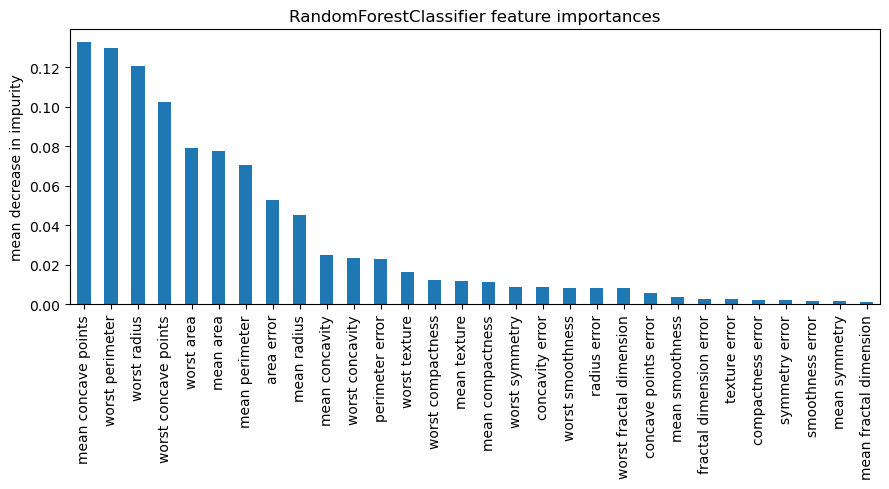

In [3]:

imp = mdl.best_estimator_.feature_importances_

rf_imp = pd.Series(imp, index=data["feature_names"]).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
rf_imp.plot.bar(ax=ax)
ax.set_title("RandomForestClassifier feature importances")
ax.set_ylabel("mean decrease in impurity")
plt.show()


In terms of mean decrease in entropy, the top 7 features are assigned the highest importance, with the remaining features deemed not as relevant. For more information on how feature importance is calcul;ated, see [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).



<br>

The resulting `mdl` object can be used to make predictions on the validation set (`mdl` exposes the `RandomForestClassifier` with optimal hyperparameters set). We use `mdl.predict_proba` to get probabilities on [0, 1], with values closer to 1 representing positive instances of breast cancer:

In [4]:

ypred = mdl.predict_proba(Xvalid)[:,1]

ypred


array([0.005     , 0.82743637, 0.97088095, 0.        , 0.        , 1.        , 0.98020202, 0.67380556, 0.        , 0.99333333, 0.9975    , 0.30048576, 0.9528113 , 0.99666667, 0.04102381, 0.99444444, 1.        , 0.828226  , 0.        , 0.        , 0.97916667, 1.        , 0.99607143, 0.90425163, 0.        , 0.02844156, 0.99333333, 0.98183333, 0.9975    , 0.08869769, 0.97369841, 0.        , 1.        , 0.71100866, 0.96022727, 0.        , 0.71200885, 0.06103175, 0.005     , 0.99490476, 0.1644127 , 0.        , 0.23646934, 1.        , 0.57680164, 0.64901715, 0.9975    , 0.61790818, 0.95509668, 0.99383333, 0.04570455, 0.97575758, 1.        , 0.47115815, 0.92422619, 0.77371415, 0.        , 1.        , 0.26198657, 0.        , 0.28206638, 0.95216162, 0.98761905, 0.99464286, 0.98704762, 0.85579351, 0.10036905, 0.00222222, 0.98011905, 0.99857143, 0.92285967, 0.95180556, 0.97546947, 0.84433189, 0.005     , 0.99833333, 0.83616339, 1.        , 0.9955    , 1.        , 0.99833333, 1.        ,
       0.

Note that scikit-learn `predict_proba`  outputs an nx2 dimensional array, where the first column represents the probability of class 0 and the second column the probability of class 1 (has breast cancer). Each row will sum to 1. We will work with the probabilities of the class we're interested in analyzing, so we extract only the values from the positive class (the second column), that's why we call `mdl.predict_proba(Xvalid)[:,1]`.

<br>

### Threshold Selection

In order to master machine learning, it is necessary to learn a variety of minor concepts that underpin these systems. One such concept is setting the optimal classification threshold.


By default, for probabilistic classifiers scikit-learn uses a threshold of .50 to distinguish between positive and negative class instances. The predicted classes are obtained by calling `mdl.predict`. Here's a side by side comparison of the model predicted probabilities and predicted classes:


In [5]:

# Predicted probabilities.
ypred = mdl.predict_proba(Xvalid)[:,1].reshape(-1, 1)


# Predicted classes.
yhat = mdl.predict(Xvalid).reshape(-1, 1)


# Combine probabilities and predicted class labels.
preds = np.concatenate([ypred, yhat], axis=1)

preds


array([[0.005     , 0.        ],
       [0.82743637, 1.        ],
       [0.97088095, 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 1.        ],
       [0.98020202, 1.        ],
       [0.67380556, 1.        ],
       [0.        , 0.        ],
       [0.99333333, 1.        ],
       [0.9975    , 1.        ],
       [0.30048576, 0.        ],
       [0.9528113 , 1.        ],
       [0.99666667, 1.        ],
       [0.04102381, 0.        ],
       [0.99444444, 1.        ],
       [1.        , 1.        ],
       [0.828226  , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.97916667, 1.        ],
       [1.        , 1.        ],
       [0.99607143, 1.        ],
       [0.90425163, 1.        ],
       [0.        , 0.        ],
       [0.02844156, 0.        ],
       [0.99333333, 1.        ],
       [0.98183333, 1.        ],
       [0.9975    , 1.        ],
       [0.08869769, 0.        ],
       [0.

Notice that when the probability is less that 0.50, the predicted class is 0. When the predicted probability is greater than 0.50, the predicted class is 1. For certain applications, the 0.50 threshold might make sense, for example when your target is balanced or close to balanced (when the number of 0s and 1s in the training set is approximately equal). But for unbalanced datasets, using the default threshold can give misleading results. In what follows, we walkthrough a few approaches that can be used to assess the optimal discrimination theshold for a classifier.



### 1. Use 0.50

The first approach is the most straightforward: Just use the default scikit-learn threshold of .50. This makes sense when your classes are balanced, but will give misleading results when classes are imbalanced.

<br>

### 2. Use 1 - the proportion of positive instances in the training data

If we look at the number of positives (1s) vs. total samples in our training set, we have:

In [6]:

print(f"Proportion of positives in training set: {ytrain.sum() / ytrain.shape[0]:.2f}")


Proportion of positives in training set: 0.62


We see that 62% of the samples belong to class 1. This is usually not the case. In many classification scenarios, we're dealing with 10%, 5% or even less than 1% of samples belonging to the positive class.

To illustrate the approach, since 62% percent of the observations belong to the positive class, we would use a threshold of **1 - .62 = .38**. The predicted class labels are then created using the following code:

In [7]:

# Creating predicted classes based on adjusted classifier threshold. 
thresh = .38

yhat = np.where(ypred <= thresh, 0, 1)


Now any sample with a predicted probability less than or equal to .38 will be assigned to class 0, and samples with predicted probability greater than .38 are assigned to the positive class.

If we're dealing with a highly imbalanced dataset with only 1% positive instances, we would use **1 - .01 = .99** as the threshold using this method. 

<br>

### 3. Use best f1-score

The f1-score is the geometric average of precision and recall. We can compute precision and recall for a number of different thresholds then select the threshold that maximizes the f1-score. This is a suitable approach if your classification task weighs precision and recall equally. Although this isn't the case for our breast cancer classifier (we want to maximize recall since the cost of a false negative is high), the approach is demonstrated in the next cell:

In [8]:

from sklearn.metrics import precision_recall_curve

# Get precision and recall for various thresholds.
p, r, thresh = precision_recall_curve(yvalid, ypred)

# Compute f1-score for each threshold.
f1 = 2 * (p * r) / (p + r)

# Identify threshold that maximizes f1-score.
best_thresh = thresh[np.argmax(f1)]

print(f"Threshold using optimal f1-score: {best_thresh:,.3f}.")


Threshold using optimal f1-score: 0.471.



Using this method, we would set the discrimination threshold to **.471**, and would obtain the predicted class labels the same way as before:

In [9]:

thresh = .471

yhat = np.where(ypred <= thresh, 0, 1)


### 4. Inspection of ROC curve

The Receiver Operating Characteristic (ROC) curve plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds. Typically we're interested in using a threshold that maximizes TPR while minimizing FPR, which is the point (0, 1). The curve starts with a threshold of 1 at the far left and decreases towards 0 as the x-axis increases. 

We can plot the ROC curve in scikit-learn using the code below. Note that `ypred` are predicted probabilities and `yvalid` are class labels (1s or 0s).


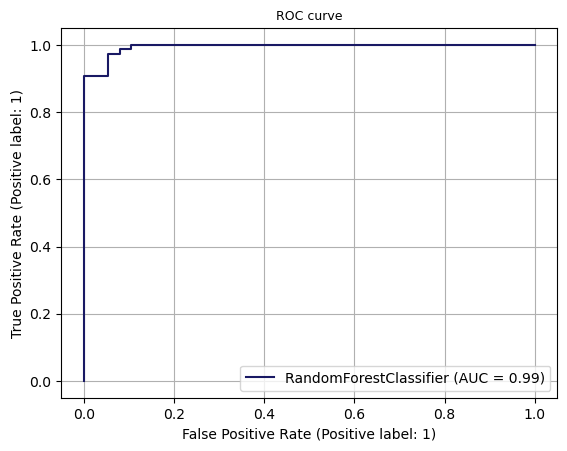

In [10]:

from sklearn.metrics import RocCurveDisplay

roc_disp = RocCurveDisplay.from_predictions(
    yvalid, ypred, name="RandomForestClassifier", color="#191964"
    )
roc_disp.ax_.set_title("ROC curve", fontsize=9)
roc_disp.ax_.grid(True)
plt.show()


Using approach 4, the optimal threshold would be somewhere between .10 and .20, which is much lower than what is indicated using the other methods. Ultimately it is up to you to determine which threshold makes the most sense, but intuitively, a threshold of .20 seems much too low when the prevalence of the positive class in the training data is 62%. 

<br>

### 5. Inspection of the precision-recall curve

The precision-recall curve is a graphical representation used in binary classification to evaluate the performance of a classification model at different probability thresholds. This curve shows the trade-off between precision and recall for a number of different thresholds. The curve plots recall on the x-axis and precision on the y-axis.

The curve starts from the rightmost part of the graph. As the threshold for classifying positive instances decreases, recall increases, and precision can either increase or decrease, but typically it decreases because the model starts to classify more instances as positive, including both true positives and false positives.

The top-right corner of the graph (high precision, high recall) represents the ideal point, where the classifier perfectly identifies all positive cases with no false positives. Generally, we'd like to select a threshold that corresponds to a point closest to top-right corner of the graph.

We can plot the Rprecision-recall curve in scikit-learn using the code below. Note that `ypred` are predicted probabilities and `yvalid` are class labels (1s or 0s).


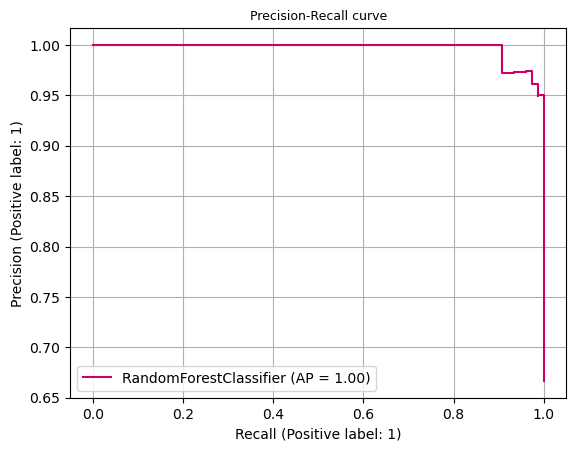

In [11]:

from sklearn.metrics import PrecisionRecallDisplay

pr_disp = PrecisionRecallDisplay.from_predictions(
    yvalid, ypred, name="RandomForestClassifier", color="#CD0066"
    )
pr_disp.ax_.set_title("Precision-Recall curve", fontsize=9)
pr_disp.ax_.grid(True)
plt.show()



Based on the plot, would want to select the threshold that corresponds to a recall of about .95, since this is close to the point (1, 1). This can be determined using the following code:

In [12]:

from sklearn.metrics import precision_recall_curve

p, r, thresh = precision_recall_curve(yvalid, ypred)

best_thresh = thresh[np.where(r >= .95)[-1][-1]]

print(f"Selected threshold using precision-recall curve: {best_thresh:,.3f}.")


Selected threshold using precision-recall curve: 0.674.


<br>

### 6. Inspection of precision and recall as a function of threshold

It is also possible to plot precision and recall as two separate series against threshold on the x-axis. The goal is to identify a point where precision and recall intersect. Using this approach may be suitable in some scenarios.

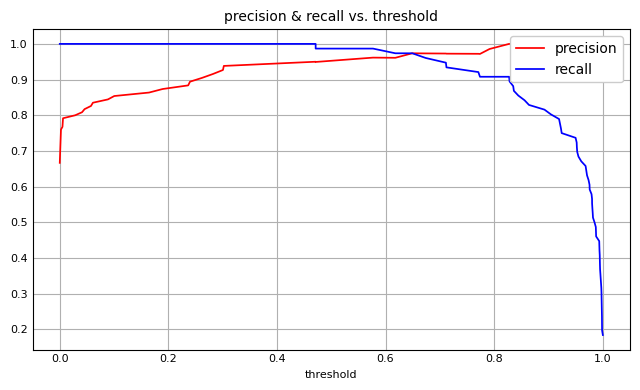

In [13]:

from sklearn.metrics import precision_recall_curve

p, r, thresh = precision_recall_curve(yvalid, ypred)
p, r = p[:-1], r[:-1]

fig, ax =  plt.subplots(1, 1, figsize=(6.5, 4), tight_layout=True)
ax.set_title("precision & recall vs. threshold", fontsize=10)
ax.plot(thresh, p, color="red", linewidth=1.25, label="precision")
ax.plot(thresh, r, color="blue", linewidth=1.25, label="recall")
ax.set_xlabel("threshold", fontsize=8)
# ax.set_xticks(np.arange(tmax+1))
ax.tick_params(axis="x", which="major", direction="in", labelsize=8)
ax.tick_params(axis="y", which="major", direction="in", labelsize=8)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.grid(True)
ax.legend(loc="upper right", fancybox=True, framealpha=1, fontsize="medium")

plt.show()


The precision and recall series intersect right after .60, therefore method \#5 would set the threshold to roughly .60.

<br>

### Assessing a Classifier


Once a threshold has been selected, the predictive power of the classifier can be assessed. To do this, we will look at the confusion matrix as well as the `sklearn.metrics.classification_report`. Note that both diagnostics require actual and predicted labels. Once we've settled on a threshold, model assessment is performed comparing actual vs. predicted labels. In what follows, the 0.471 threshold obtained from method \#3 will be used as the classification threshold. 

Technically, once we've decided on a threshold, we should then assess the performance of the model on a separate test set. However, for the purposes of demonstration, we are going to re-use the validation set. 

We start by creating the confusion matrix:

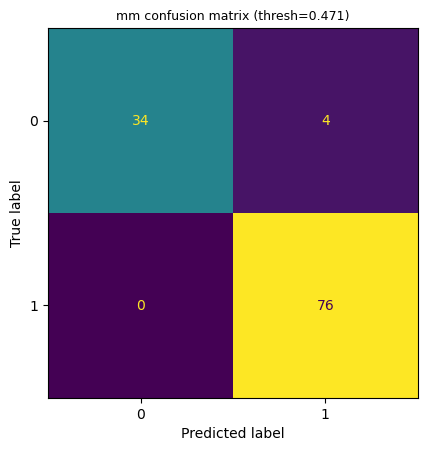

In [16]:

from sklearn.metrics import ConfusionMatrixDisplay

# Determine predicted classes using the .471 threshold.
thresh = .471
yhat = np.where(ypred <= thresh, 0, 1)

cm_disp = ConfusionMatrixDisplay.from_predictions(yvalid, yhat, colorbar=False)
cm_disp.ax_.set_title(f"mm confusion matrix (thresh={thresh:.3})", fontsize=9)
plt.show()


The output indicates:

- There are 76 True Positives (TP).
- There are 34 True Negatives (TN).
- There are 4 False Positives (FP).
- There are 0 False Negatives (FN).


<br>

Next we inspect the classification report. This also takes actual and predicted labels, and returns a summary of common classifier metrics:

In [17]:

from sklearn.metrics import classification_report

print(classification_report(yvalid, yhat))


              precision    recall  f1-score   support

           0       1.00      0.89      0.94        38
           1       0.95      1.00      0.97        76

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114




Overall this is very good performance. 